In [5]:
from JupyterImport import *
from plotly.subplots import make_subplots
import progressbar
from progressbar import progressbar as prog
from sys import stdout
import plotly.express as px
from src.DataStandardize.ExpSpecific.Aug20 import Fixes
from src.DatObject.Attributes import Entropy as E, Transition as T, SquareEntropy as SE, DatAttribute as DA
root_logger.setLevel(logging.WARNING)

In [6]:
save_graphs=False
filter_on = True

In [7]:
# datnums = list(range(1069, 1073+1)) + list(range(1089, 1094+1))
# datnums = sorted(list(set(range(1144, 1287+1)) - {1249, 1250, 1251, 1252, 1253}))
datnums = range(1144, 1303)

dats = get_dats(datnums, progress = True)

dats = [dat for dat in dats if dat.AWG.info.num_steps > 80]

for dat in progressbar.progressbar(dats, redirect_stdout=False):
        Fixes._add_magy(dat)  # Adds temporary magy field to Other.magy
    #     dT = 8.7
        dat.SquareEntropy.Processed.plot_info.show = SE.ShowPlots(info=True, raw=True, averaged=True, entropy=True)
        dat.SquareEntropy.ShowPlots.integrated = True
dats = [dat for dat in dats if dat.SquareEntropy.Processed.outputs.entropy_fit is not None]

N/A% (0 of 159) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--WARNING:src.DataStandardize.BaseClasses:Tried updating local data folder, but still can't find Exp data for dat1144


FileNotFoundError: No experiment data found for dat1144 in:D:\OneDrive\UBC LAB\My work\Fridge_Measurements_and_Devices\Fridge Measurements with PyDatAnalysis\Sep20\Experiment_Data

In [3]:
xs, trans_datas, entropy_datas, integrated_datas, ids, trans_titles, entropy_titles, integrated_titles, tcs, ths, dTs = list(), list(), list(), list(), list(), list(), list(), list(), list(), list(), list()
line = lm.models.LinearModel()
for dat in progressbar.progressbar(dats, redirect_stdout=False):
    stdout.flush()
    
    x = dat.SquareEntropy.Processed.outputs.x
    ids.append(f'{dat.datnum}')
    
    dat_tcs, dat_amps = list(), list()
    for data in dat.SquareEntropy.Processed.outputs.averaged[0::2]:
        fit = T.transition_fits(x, data, func=T.i_sense)[0]
        dat_tcs.append(fit.best_values['theta'])
        dat_amps.append(fit.best_values['amp'])
    dat_ths = list()
    for data in dat.SquareEntropy.Processed.outputs.averaged[1::2]:
        fit = T.transition_fits(x, data, func=T.i_sense)[0]
        dat_ths.append(fit.best_values['theta'])
    tc = np.nanmean(dat_tcs)
    th = np.nanmean(dat_ths)
    dT = th-tc
    tcs.append(tc)
    ths.append(th)
    dTs.append(dT)
    
    amp = np.average(dat_amps)
    dat.SquareEntropy.Processed.inputs.dT = dT
    dat.SquareEntropy.Processed.inputs.transition_amplitude = amp
    dat.SquareEntropy.process()
    integrated_data = dat.SquareEntropy.Processed.outputs.integrated_entropy
    indexs = CU.get_data_index(x, [-500, -200])
    line_fit = line.fit(integrated_data[indexs[0]:indexs[1]], x=x[indexs[0]:indexs[1]], nan_policy='omit')
    integrated_data = integrated_data-line_fit.eval(x=x)
    
    e_signal = dat.SquareEntropy.Processed.outputs.entropy_signal
    e_pars = CU.edit_params(dat.SquareEntropy.Processed.outputs.entropy_fit.params, 'const', 0, True)
    efit = E.entropy_fits(x, e_signal, params=e_pars)[0]
    efit_info = DA.FitInfo()
    efit_info.init_from_fit(efit)
    
    td = dat.SquareEntropy.Processed.outputs.averaged
    ed = [efit_info.eval_fit(x=x), e_signal]
    intd = integrated_data
    if filter_on is True:
        scan_freq = dat.Logs.Fastdac.measure_freq/dat.AWG.info.wave_len
        num_steps = dat.AWG.info.num_steps
        decimate_factor = int(np.floor(num_steps/200))
        if decimate_factor >= 2:
            td = CU.decimate(td, scan_freq, decimate_factor=decimate_factor)
            x = np.linspace(x[0], x[-1], td.shape[-1])
            ed = [efit_info.eval_fit(x=x), CU.decimate(ed[1], scan_freq, decimate_factor=decimate_factor)]
            intd = CU.decimate(intd, scan_freq, decimate_factor=decimate_factor)
        else:
            pass  # Decimate factor must be 2 or more
    else:
        pass
    xs.append(x)
    trans_datas.append(td)
    entropy_datas.append(ed)
    integrated_datas.append(intd)
    
    channel_ratio = round(dat.AWG.AWs[1][0][1]/dat.AWG.AWs[0][0][1]/-0.033, 1)
    dsp = dat.SquareEntropy.Processed
    ii = dsp.outputs.integrated_info
    fit_text = f'SF={ii.sf:.2f}, Amp={ii.amp:.3f}nA, T_cold={tc:.3f}mV, T_hot={th:.3f}mV, dT={dT:.3f}mV, fit_dS={efit_info.best_values.dS:.3f}kB'
    scan_text = f'HQPCbiases=({dat.AWG.AWs[0][0][1]:.0f}mV, {dat.AWG.AWs[0][0][3]:.0f}mV), Channel Biases=({dat.AWG.AWs[1][0][1]:.1f}mV, {dat.AWG.AWs[1][0][3]:.1f}mV)'
    array_text = f'Channel Bias Ratio = {channel_ratio}, Square Wave Frequency = {scan_freq:.1f}Hz, Sweeprate (LP*200) = {dat.Logs.sweeprate:.1f}mV/s'
    text_info = f'{array_text}<br>{scan_text}<br>{fit_text}'
    trans_titles.append(f'Dat{dat.datnum}: Averaged CS data<br>{text_info}')
    entropy_titles.append(f'Dat{dat.datnum}: Entropy data with fit<br>{text_info}')
    integrated_titles.append(f'Dat{dat.datnum}: Integrated Entropy data<br>{text_info}')
    
    
fig1 = PlU.get_figure(datas=trans_datas, xs=xs, ids=ids, titles=trans_titles, labels=['v0_0', 'vp', 'v0_1', 'vm'], xlabel=f'{dat.Logs.x_label}', ylabel='Current /nA', plot_kwargs={'mode':'lines+markers'})
fig2 = PlU.get_figure(datas=entropy_datas, xs=xs, ids=ids, titles=entropy_titles, labels=['fit', 'data'], xlabel=f'{dat.Logs.x_label}', ylabel='Current /nA', plot_kwargs={'mode':'lines+markers'})
fig3 = PlU.get_figure(datas=integrated_datas, xs=xs, ids=ids, titles=integrated_titles, xlabel=f'{dat.Logs.x_label}', ylabel='Entropy /kB', plot_kwargs={'mode':'lines+markers'})

NameError: name 'lm' is not defined

In [4]:
for fig, name in zip([fig1, fig2, fig3], ['AveragedCS_vs_Channel_bias', 'Average_Entropy_With_Fit', 'Averaged_Integrated_Entropy']):
    fig.update_layout(hovermode = 'x unified')
    if save_graphs: 
        fig.write_html(f'Exports/Dats{dats[0].datnum}-{dats[-1].datnum}{name}.html')
    fig.show()

NameError: name 'fig1' is not defined

In [17]:
dat = get_dat(1273)
print(dat.Logs.comments)
print(dat.AWG.info)
dat.Data.y_array.shape


square entropy, Testing scan parameters frequency and sweeprate, Channel potential ratios, -100mT, 50mK, Channel Ratio Multiplier = 1.0, SW Frequency = 45.0Hz, Sweeprate LP*200 = 140.0mV/s, Num_repeats = 42
AWGtuple(measureFreq=2538.1, num_adcs=1, num_cycles=1, num_steps=324, outputs={0: [0], 1: [1]}, samplingFreq=2538.1, wave_len=56)


(42,)

In [31]:
# dats = get_dats(range(1074, 1088+1))
# dats = get_dats(range(1095, 1109+1))
# dats = get_dats(range(1110, 1124+1))
dats = get_dats(range(1126, 1140+1))

thetas = [dat.Transition.avg_fit.best_values.theta for dat in dats]
mids = [dat.Transition.avg_fit.best_values.mid for dat in dats]
bias = [dat.Logs.fds['R2T(10M)'] for dat in dats]

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 6
    # data points      = 15
    # variables        = 2
    chi-square         = 1371.49067
    reduced chi-square = 105.499282
    Akaike info crit   = 71.7340496
    Bayesian info crit = 73.1501500
[[Variables]]
    slope:     -0.00994061 +/- 0.00999853 (100.58%) (init = 1)
    intercept:  93.4431976 +/- 2.65203423 (2.84%) (init = 0)


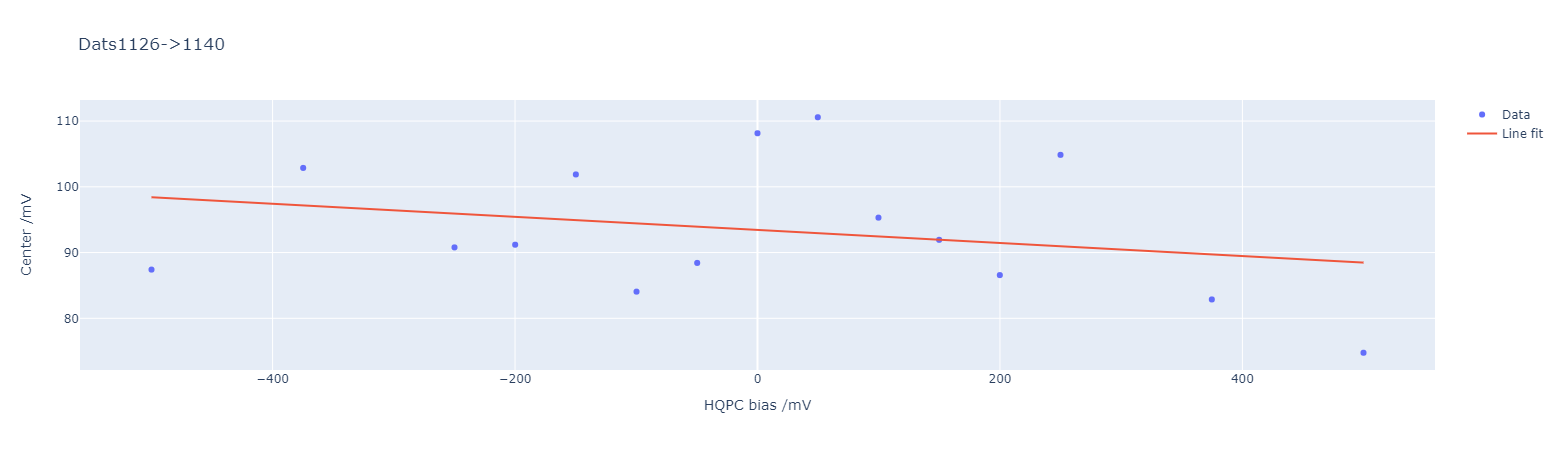

In [32]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=bias, y=mids, mode='markers', name='Data'))

line = lm.models.LinearModel()
fit = line.fit(mids, x=bias)
fig.add_trace(go.Scatter(x=bias, y=fit.eval(x=np.array(bias)), name='Line fit', mode='lines'))
fig.update_layout(title=f'Dats{dats[0].datnum}->{dats[-1].datnum}', xaxis_title='HQPC bias /mV', yaxis_title='Center /mV')
print(fit.fit_report())
fig.show()

line through TC vs LP    $TC = 0.772*LP - 21.4$

line through LP vs HQPC $LP = 0.043*HQPC - 0.01$

$TC  = 0.772*0.043*HQPC $

$TC = 0.033*HQPC$

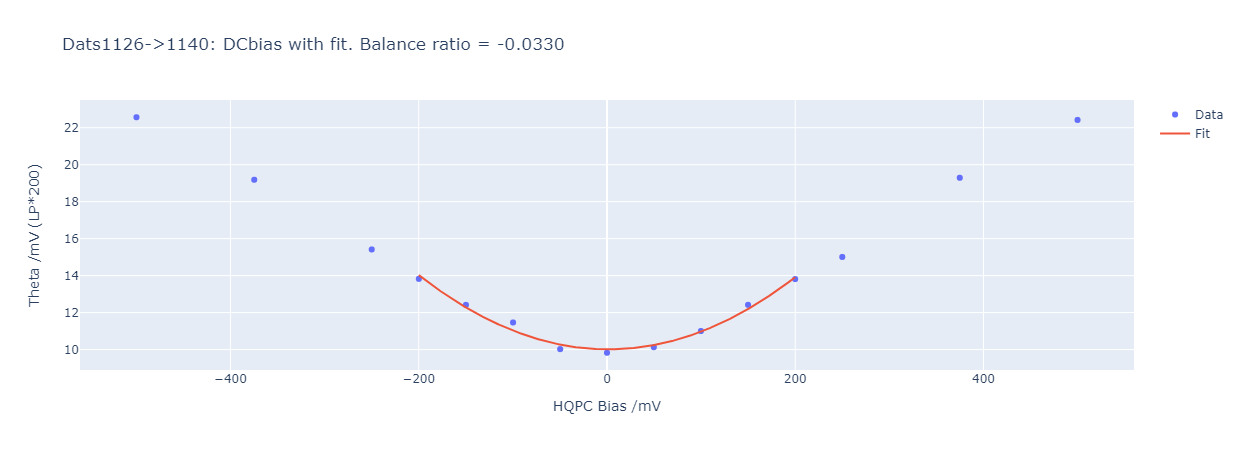

In [37]:
idxs = CU.get_data_index(bias, [-200, 200])

quad = lm.models.QuadraticModel()
pars = quad.make_params()
pars['b'].value = 0
pars['b'].vary = True
ftheta = thetas[idxs[0]:idxs[1]+1]
fbias= bias[idxs[0]:idxs[1]+1]
fit = quad.fit(ftheta, x=fbias, params=pars)

fig = go.Figure()
fig.add_trace(go.Scatter(x=bias, y=thetas, name='Data', mode='markers'))
x = np.linspace(fbias[0], fbias[-1], 1000)
fig.add_trace(go.Scatter(x=x, y=fit.eval(x=x), name='Fit', mode='lines'))
fig.update_layout(xaxis_title='HQPC Bias /mV', yaxis_title='Theta /mV (LP*200)', title=f'Dats{dats[0].datnum}->{dats[-1].datnum}: DCbias with fit. Balance ratio = {dats[0].Logs.fds["TC/0.001"]/dats[0].Logs.fds["R2T(10M)"]:.4f}')
if save_graphs: fig.write_html(export_path+f'Dats{dats[0].datnum}-{dats[-1].datnum}DCbiasWithFit.html')
fig.show()

In [36]:
print(fit.best_values)

{'a': 9.910069505948479e-05, 'b': -0.0002894824140346562, 'c': 10.009498714214573}


Sunday, August 23, 2020 05:31:57
771.91


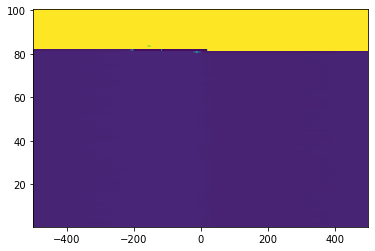

In [23]:
%matplotlib inline
dat = get_dat(1332)
fig, ax = plt.subplots(1,1)
P.display_2d(dat.Data.x_array, dat.Data.y_array, dat.Data.i_sense, ax)
print(dat.Logs.time_completed)
print(dat.Logs.time_elapsed)